In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import global_params as G
plt.rcParams['figure.figsize'] = G.SMALL_FIG

In [3]:
import numpy as np
from scipy import signal
from scipy.fftpack import fft

np.set_printoptions(precision=4, suppress=True)

In [4]:
from itertools import zip_longest

In [5]:
from freq_domain import plotspec
from utilities import power

from transmitter import *
from receiver import *
from impairments import *

## Section 9.1

### Parameters

In [6]:
# Tx/Rx parameters
msg = '01234 I wish I were an Oscar Meyer wiener 56789'
fc = 20 # Carrier frequency
oversample_factor = 100 # oversampling factor
taps = 50

In [7]:
# Impairment parameters
noise_gain = 0
multipath_condition = 'none' # none, mild, harsh
freq_offset = 0 # As percentage of carrier frequency
phase_offset = 0.9 # In radians
timing_offset = 0 # Percentage of symbol period
symbol_period_offset = 0 # 0 or 1 - changes symbol period

### Transmitter design

In [8]:
M = oversample_factor - symbol_period_offset

[-3, 3, -3, -3, -3]

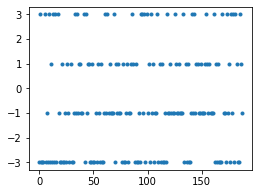

In [9]:
# Convert to PAM symbols
symbols = letters2pam(msg)
plt.plot(symbols, '.');
symbols[:5]

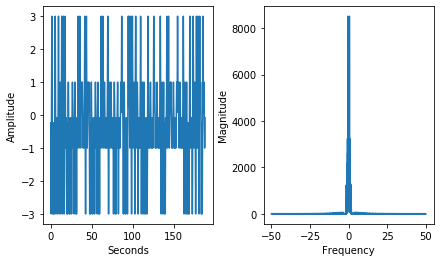

In [10]:
# Pulse shaping with a hamming pulse
analog_waveform = pulse_shaped(symbols, M)
Ts = 1/M
plotspec(analog_waveform, 1/M);

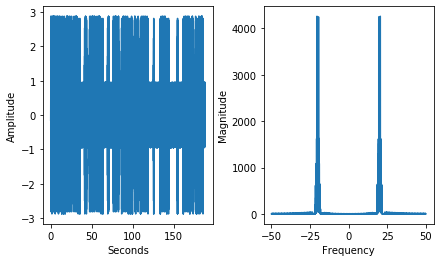

In [11]:
t, transmitted = modulate(analog_waveform, fc*(1+0.01*freq_offset), 1/M, phase_offset)
plotspec(transmitted, 1/M);

### Impairments

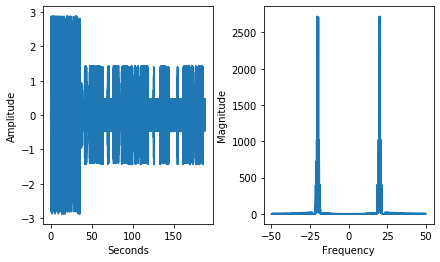

In [12]:
# Fading
faded = time_varying_fading_channel(transmitted)
plotspec(faded, Ts);

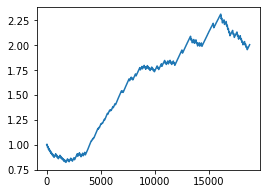

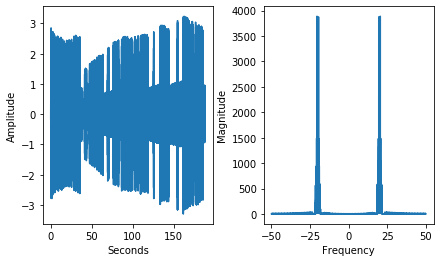

In [13]:
# AGC to combat time varying fading
sig_after_agc, gains = agc(faded, power(transmitted))
plt.plot(gains);
plotspec(sig_after_agc, Ts);

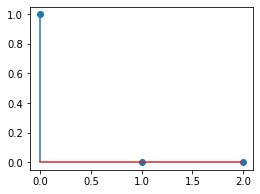

In [14]:
# Multipath
multipath, channel = create_multipath(transmitted, multipath_condition)
plt.stem(channel, use_line_collection=True);

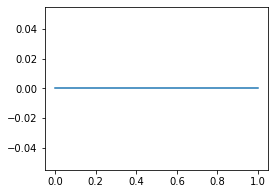

In [15]:
w, h = signal.freqz(channel, 1)
plt.plot(w/np.pi, 20*np.log10(np.abs(h)));

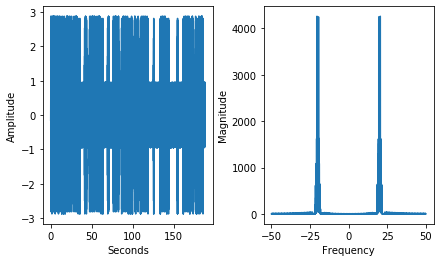

In [16]:
# AWGN
noisy_sig = add_noise(multipath, noise_gain)
plotspec(noisy_sig, Ts);

In [17]:
# Fractional period delay
# Simulates offset in Symbol clock , 
# e.g., the first PAM sqaure wave may not be of the full symbol duration
start_offset = int(timing_offset * 0.01 * M)
signal_with_symbol_offset = noisy_sig[start_offset:]

### Receiver design

In [18]:
# Rx can assume wrong symbol period
rx_M = M + symbol_period_offset
received = noisy_sig

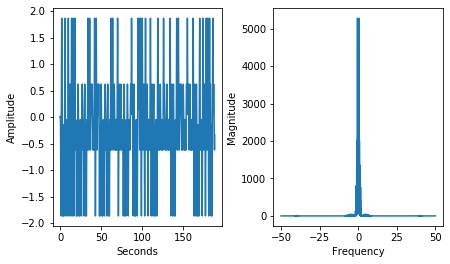

In [19]:
Ts = 1/rx_M
baseband = demodulate(received, fc, Ts)
plotspec(baseband, Ts);

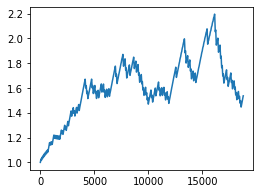

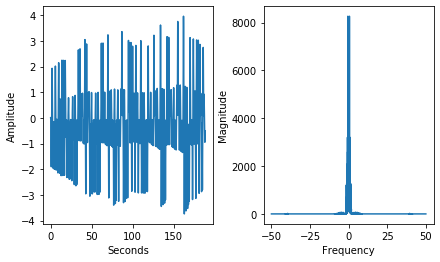

In [20]:
# Ex 9.8 - Use a AGC to combat phase offset
sig_after_agc, gains = agc(baseband, power(analog_waveform))
plt.plot(gains);
plotspec(sig_after_agc, Ts);
#baseband = sig_after_agc

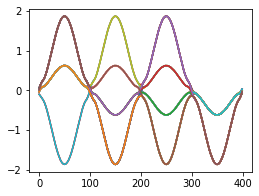

In [21]:
# Eye Diagram at baseband
sampling_start_idx = 25 + 100 - 1
num_groups = len(baseband[sampling_start_idx:])//(4*rx_M)
noisy_eye_diag = baseband[sampling_start_idx:sampling_start_idx+num_groups*4*rx_M].reshape(-1, 4*rx_M)
plt.plot(noisy_eye_diag.T); 

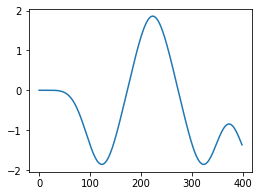

In [22]:
correlated = pulse_correlator(baseband, rx_M)
# Filter delay of linear phase filter is (taps-1)/2 = 24.5, round to 25
# Peak for correlate(pulse, pulse) is at M - 1 = 99
# First best sampling time = 99 + 25 = 124
# After that, sample every M = 100 samples
plt.plot(correlated[:4*rx_M]);
# The plot below corresponds to the first three symbols [-3, 3, -3]

In [23]:
# Check group delay of linear phase filter explicitly
# See explanations here:
# https://dsp.stackexchange.com/questions/18435/group-delay-of-the-fir-filter
# https://www.mathworks.com/help/signal/ug/compensate-for-the-delay-introduced-by-an-fir-filter.html
Fs = 1/Ts
band_edges = np.array([0, 0.1, 0.2, 1])*(Fs//2) # Cutoff at 0.2*Fs/2
damps = [1, 0]
b = signal.remez(taps, band_edges, damps, fs=Fs)
w, gd = signal.group_delay((b, 1))
gd.mean().round(2)

24.5

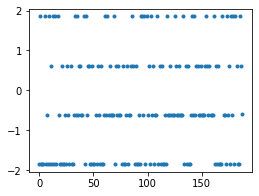

In [24]:
filter_delay = 25 # taps // 2
correlator_delay = rx_M
sampling_start_idx = filter_delay + correlator_delay - 1
soft_decisions = correlated[sampling_start_idx::rx_M]
plt.plot(soft_decisions, '.');

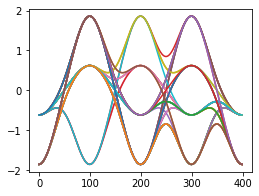

In [25]:
# Eye Diagram
num_groups = len(correlated[sampling_start_idx:])//(4*rx_M)
#print(num_groups)
grouped_data = correlated[sampling_start_idx:sampling_start_idx+num_groups*4*rx_M].reshape(-1, 4*rx_M)
#print(grouped_data.shape)
plt.plot(grouped_data.T); 

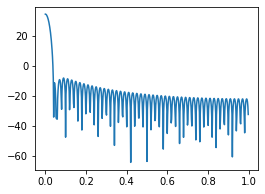

In [26]:
# The pulse correlator actually works like a low pass filter
correlator_filter = signal.hamming(100)
w, h = signal.freqz(correlator_filter, 1)
plt.plot(w/np.pi, 20*np.log10(np.abs(h)));

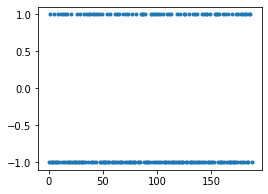

In [27]:
alphabet = np.array([-3, -1, 1, 3])
hard_decisions = quantalph(soft_decisions, alphabet)
plt.plot(hard_decisions, '.');

In [28]:
decoded_msg = pam2letters(hard_decisions)
num_errors = sum([dec != orig for dec, orig in zip_longest(decoded_msg, msg)])
print(f'Errors: {num_errors}')
decoded_msg

Errors: 39


'eeffeeYefifieYefefeeejeZffefeYeiefefiejefeeffii'